## Test Accuracy: 0.74006
### Input: tokens = [ ] , tags = [ ]
#### (embedding): Embedding(8140, 128, padding_idx=0)
#### (fc1): Linear(in_features=128, out_features=256, bias=True)
#### (relu): ReLU()
#### (dropout): Dropout(p=0.5, inplace=False)
#### (fc2): Linear(in_features=128, out_features=224, bias=True)

In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import Counter
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
from plot_utils import plot, plot_loss_acc, plot_train_val

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
def get_txt_file_paths(folder):
    txt_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                txt_files.append(os.path.join(root, file))
    return txt_files

file_paths = get_txt_file_paths("corpus")
print(f"Total .txt files found: {len(file_paths)}")

Total .txt files found: 76


In [4]:
def parse_tagged_line(line):
    tokens = []
    tags = []
    for item in line.strip().split():
        if '/' in item:
            word, tag = item.rsplit('/', 1)
            tokens.append(word)
            tags.append(tag)
    return tokens, tags

In [5]:
class GaelicPoSDataset(Dataset):
    def __init__(self, file_paths):
        self.total_tokens = []
        self.total_tags = []
        for path in file_paths:
            with open(path, encoding='utf-8') as f:
                for line in f:
                    tokens, tags = parse_tagged_line(line)
                    self.total_tokens.extend(tokens)
                    self.total_tags.extend(tags)
    def  __len__(self):
        return len(self.total_tokens)
    
    def __getitem__(self, index):
        return self.total_tokens[index], self.total_tags[index]

In [6]:
dataset = GaelicPoSDataset(file_paths)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
split_train, split_valid = train_test_split(train_dataset, test_size=0.2, random_state=42)

In [7]:
def yield_token(dataset):
    for token, _ in dataset:
        yield [token]
        
def yield_tag(dataset):
    for _, tag in dataset:
        yield [tag]
        
        
token_vocab = build_vocab_from_iterator(yield_token(dataset), specials=["<pad>", "<unk>"])
token_vocab.set_default_index(token_vocab["<unk>"])

tag_vocab = build_vocab_from_iterator(yield_tag(dataset), specials=["<pad>"])
tag_vocab.set_default_index(tag_vocab["<pad>"])

In [8]:
def collate_batch(batch):
    tokens, tags = zip(*batch)  # unzip into two lists
    token_ids = torch.tensor([token_vocab[token] for token in tokens], dtype=torch.long)
    tag_ids = torch.tensor([tag_vocab[tag] for tag in tags], dtype=torch.long)
    return token_ids, tag_ids

In [9]:
class PosTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embed_dim=100, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, tagset_size)

            
    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    split_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(
    split_valid, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch )
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [11]:
model = PosTagger(
    vocab_size = len(token_vocab),
    tagset_size = len(tag_vocab),
    embed_dim = 128,
    hidden_dim=128
).to(device)
model

PosTagger(
  (embedding): Embedding(8140, 128, padding_idx=0)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=224, bias=True)
)

In [12]:
loss_function = nn.CrossEntropyLoss(ignore_index=tag_vocab["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for tokens, tags in dataloader:
            outputs = model(tokens)
            predicted = outputs.argmax(dim=1)
            mask = tags != tag_vocab["<pad>"]
            total_acc += ((predicted == tags) & mask).sum().item()
            total_count += mask.sum().item()
            
    return total_acc / total_count if total_count > 0 else 0

In [14]:
epochs = 10
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for tokens, tags in train_dataloader:
        tokens, tags = tokens.to(device), tags.to(device)
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = loss_function(outputs, tags)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss_list.append(total_train_loss)
    
    train_acc = evaluate(train_dataloader)
    train_acc_list.append(train_acc)
    
    val_acc = evaluate(valid_dataloader)
    val_acc_list.append(val_acc)
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tokens, tags in valid_dataloader:
            tokens, tags = tokens.to(device), tags.to(device)
            outputs = model(tokens)
            loss = loss_function(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            total_val_loss += loss.item()
    val_loss_list.append(total_val_loss)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
    
    print(f"Epoch {epoch + 1}: Train Loss = {total_train_loss:.4f}, Train Accuracy = {train_acc:.4f}, "
          f"Validation Loss = {total_val_loss:4f}, Validation Accuracy = {val_acc:.4f}")

Epoch 1: Train Loss = 3662.6701, Train Accuracy = 0.6475, Validation Loss = 616.837923, Validation Accuracy = 0.6398
Epoch 2: Train Loss = 2466.1693, Train Accuracy = 0.6957, Validation Loss = 525.497470, Validation Accuracy = 0.6811
Epoch 3: Train Loss = 2126.3775, Train Accuracy = 0.7222, Validation Loss = 481.428333, Validation Accuracy = 0.7006
Epoch 4: Train Loss = 1908.5304, Train Accuracy = 0.7454, Validation Loss = 457.211169, Validation Accuracy = 0.7161
Epoch 5: Train Loss = 1742.6390, Train Accuracy = 0.7515, Validation Loss = 447.358716, Validation Accuracy = 0.7177
Epoch 6: Train Loss = 1615.8533, Train Accuracy = 0.7677, Validation Loss = 438.624368, Validation Accuracy = 0.7265
Epoch 7: Train Loss = 1506.3866, Train Accuracy = 0.7760, Validation Loss = 436.358882, Validation Accuracy = 0.7335
Epoch 8: Train Loss = 1426.6772, Train Accuracy = 0.7879, Validation Loss = 439.349975, Validation Accuracy = 0.7379
Epoch 9: Train Loss = 1360.3003, Train Accuracy = 0.7920, Valida

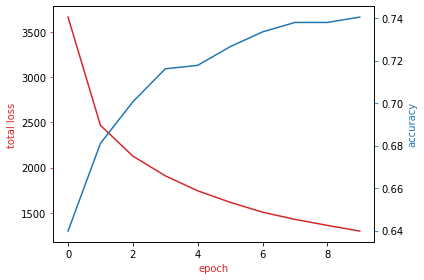

In [15]:
plot(train_loss_list, val_acc_list)

### Accuracy of the model

In [16]:
model.load_state_dict(torch.load("best_model.pt"))
test_acc = evaluate(test_dataloader)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.7400620404411765


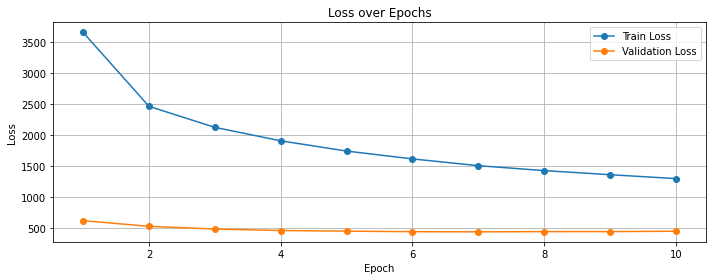

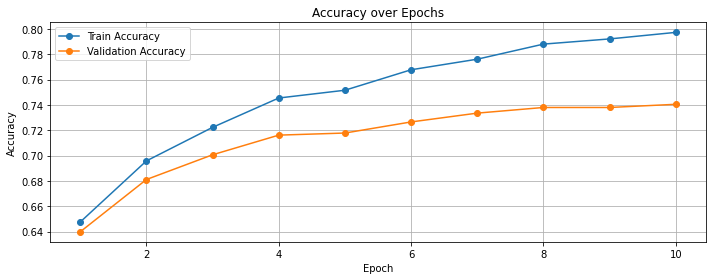

In [17]:
plot_train_val(epochs, train_loss_list, val_loss_list, train_acc_list, val_acc_list)